In [1]:
import numpy as np
from numpy.random import multivariate_normal
import scipy as scp
import sklearn
from scipy.sparse.csgraph import laplacian as sp_laplacian
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import mutual_info_score as mi
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

N_SAMPLES = 1000

In [2]:
def get_synth_data():
    c1_means = [[1, 1],[1, 2],[1, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [3]:
def get_synth_data2():
    datafile1 = './Data/view1.csv'
    datafile2 = './Data/view2.csv'
    datafile3 = './Data/view3.csv'
    labelfile = './Data/labels.csv'

    v1_data = np.loadtxt(datafile1, delimiter = ',')
    v2_data = np.loadtxt(datafile2, delimiter = ',')
    v3_data = np.loadtxt(datafile3, delimiter = ',')
    labels = np.loadtxt(labelfile, delimiter = ',')
    v_data = [v1_data, v2_data, v3_data]
    
    return v_data, labels


In [4]:
v_data, labels = get_synth_data2()

In [5]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    norm_dists = sq_dists  / (2 * np.median(sq_dists))
    sims = np.exp(-norm_dists)
    
    return sims
    
def sym(S_mat):
    mat =  (S_mat + np.transpose(S_mat)) / 2.0
    return mat

def comp_laplacian(X_mat):
    D_mat = np.diag(np.sum(X_mat, axis=1))
    D_alt = np.sqrt(np.linalg.inv(np.abs(D_mat))) 
    laplacian = D_alt @ X_mat @ D_alt
    laplacian = sym(laplacian)
    return laplacian

def comp_eigs(X_mat, k):
    laplacian = comp_laplacian(X_mat)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(np.real(e_vals))[-k:]
    e_vecs = np.real(e_vecs[:,indices])
    return e_vecs


    

In [6]:
def single_spectral(U_mats, labels, k=2):

    #Row normalize 
    U_norm = np.linalg.norm(U_mats, axis = 1).reshape((-1, 1))
    U_norm[U_norm == 0] = 1
    V_mats = U_mats/ U_norm 
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(V_mats)
    nmi = nmi_score(clusters, labels)
    return nmi

In [7]:
def multiview_spectral(v_data, labels, k=2, num_iter = 10):
    #Compute the similarities matrices
    sims = [gaussian_sim(dat) for dat in v_data]
    
    #Initialize matrices of eigenvectors
    U_mats = [comp_eigs(sim, k) for sim in sims]
    
    nmi_vals = list()
    #Iteratively compute new graph similarities, laplacians, and eigenvectors
    for iter in range(num_iter):
        
        eig_sums = [u_mat @ np.transpose(u_mat) for u_mat in U_mats]
        U_sum = np.sum(np.array(eig_sums), axis=0)
        
        print(iter)
        new_sims = list()
        
        for view in range(len(v_data)):
            mat1 = sims[view] @ (U_sum - U_mats[view] @ np.transpose(U_mats[view]))
            new_sims.append(sym(mat1))
        U_mats = [comp_eigs(sim, k) for sim in new_sims]  
        
        #Compute nmi for each view per iteration
        nmi_set = list()
        for ind in range(len(v_data)):
            nmi = single_spectral(U_mats[ind], labels, k)
            nmi_set.append(nmi)
            print('nmi for view ' + str(ind) + ' is: ' + str(nmi))
        nmi_vals.append(nmi_set)
        
        
    #Row normalize 
    for view in range(len(v_data)):
        U_norm = np.linalg.norm(U_mats[view], axis = 1).reshape((-1, 1))
        U_norm[U_norm == 0] = 1
        U_mats[view] /= U_norm 
    #Columnwise concatenation across all views
    V_mat = np.hstack(U_mats)    
    kmeans = KMeans(n_clusters=k, n_init=100)
    clusters = kmeans.fit_predict(V_mat)
    return clusters, nmi_vals
    

In [8]:
clusters, nmi_vals = multiview_spectral(v_data, labels, k=2)


0
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.9279834219814302
nmi for view 2 is: 0.8817553942679613
1
nmi for view 0 is: 0.9731568159043371
nmi for view 1 is: 0.7592885643486819
nmi for view 2 is: 0.7756512738766882
2
nmi for view 0 is: 0.9809123277916382
nmi for view 1 is: 0.7882082778761301
nmi for view 2 is: 0.8087995134687997
3
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.7735037484040788
nmi for view 2 is: 0.8039738318512195
4
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.7735037484040788
nmi for view 2 is: 0.8087995134687997
5
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.7735037484040788
nmi for view 2 is: 0.8034276755965473
6
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.7735037484040788
nmi for view 2 is: 0.8034276755965473
7
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.7735037484040788
nmi for view 2 is: 0.8034276755965473
8
nmi for view 0 is: 0.9894379529654227
nmi for view 1 is: 0.77350374840

In [9]:
nmi_vals = np.array(nmi_vals).transpose()
print(nmi_vals.shape)

(3, 10)


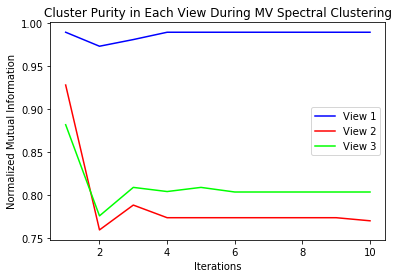

In [10]:
# My implementation
x_vals = list(range(1,11))
plt.plot(x_vals, nmi_vals[0], 'b' , x_vals, nmi_vals[1], 'r', 
         x_vals, nmi_vals[2], 'lime')
plt.xlabel('Iterations')
plt.ylabel('Normalized Mutual Information')
plt.legend(['View 1','View 2','View 3'])
plt.title('Cluster Purity in Each View During MV Spectral Clustering')
plt.show()

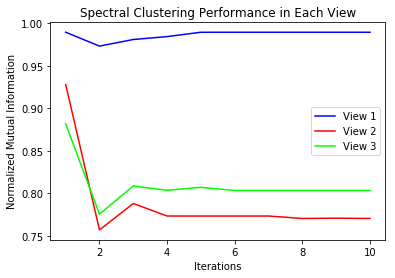

In [11]:
# Results produced by code from the paper
resultfile = './Data/results.csv'
paper_results = np.loadtxt(resultfile, delimiter = ',')
paper_results = np.transpose(paper_results)
x_vals = list(range(1,11))
plt.plot(x_vals, paper_results[0], 'b' , x_vals, paper_results[1], 'r', 
         x_vals, paper_results[2], 'lime')
plt.xlabel('Iterations')
plt.ylabel('Normalized Mutual Information')
plt.legend(['View 1','View 2','View 3'])
plt.title('Spectral Clustering Performance in Each View')
plt.show()

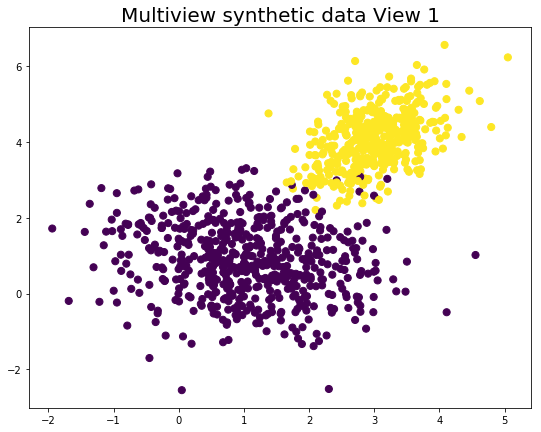

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview synthetic data View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=clusters,s=dot_size, cmap=cmap)

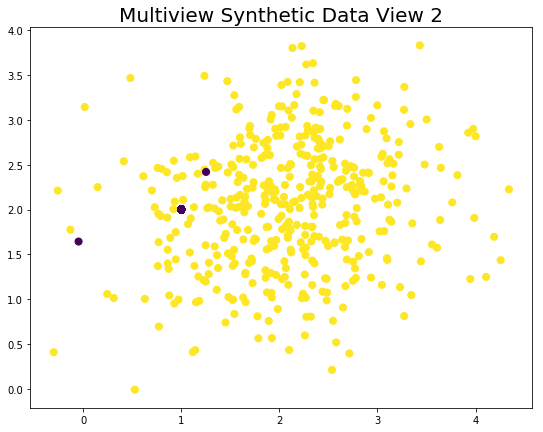

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview Synthetic Data View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=clusters,s=dot_size, cmap=cmap)

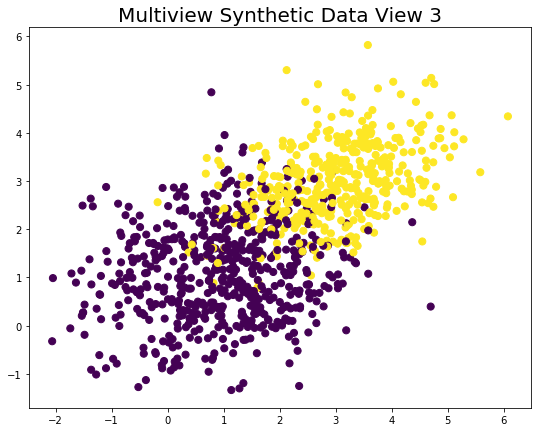

In [14]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview Synthetic Data View 3', size=20)
ax.scatter(v_data[2][:, 0], v_data[2][:, 1],c=clusters,s=dot_size, cmap=cmap)

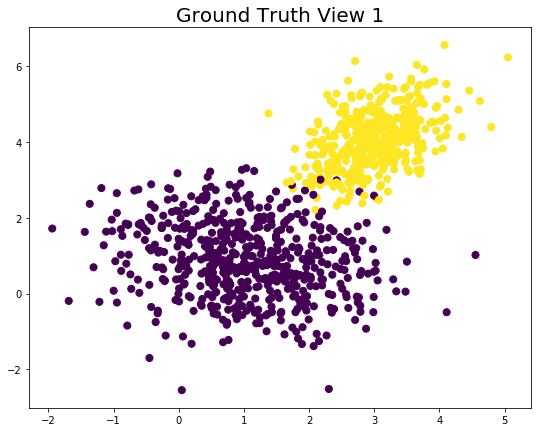

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=labels,s=dot_size, cmap=cmap)

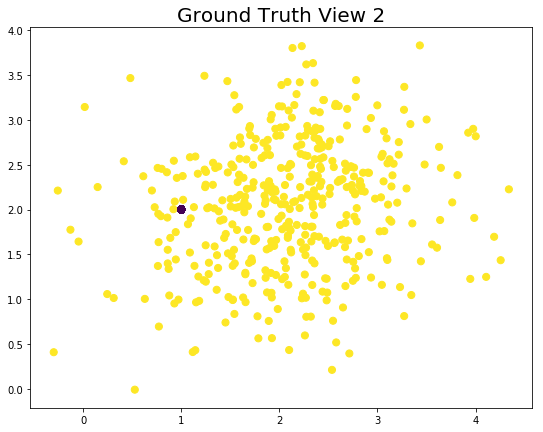

In [16]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 2', size=20)
ax.scatter(v_data[1][:, 0], v_data[1][:, 1],c=labels,s=dot_size, cmap=cmap)

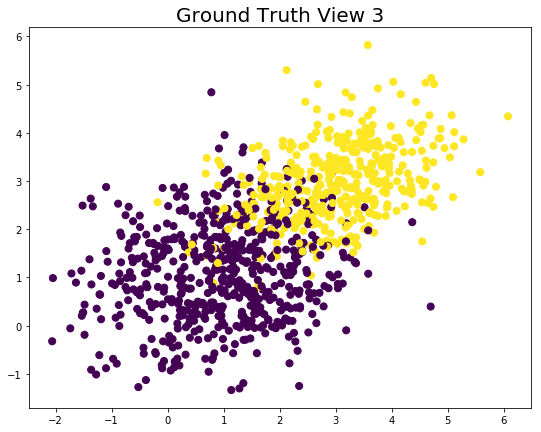

In [17]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 3', size=20)
ax.scatter(v_data[2][:, 0], v_data[2][:, 1],c=labels,s=dot_size, cmap=cmap)